# Data Processing

In [1]:
path_train = u"../src/data/processed/train.mini.csv"

In [2]:
path_val = u"../src/data/processed/val.mini.csv"

Reading in word vectors. Reduced to 500k due to RAM limits.

**Todo:** Filter for those vocabularies that are actually in the whole data set.

In [3]:
%%time
import gensim
import numpy as np
embedding_model = gensim.models.KeyedVectors.load_word2vec_format('../src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True, limit=500000)
embedding_model.add('<oov>', np.mean(embedding_model.vectors, axis=0),replace=False)
embedding_model.add('<padding>', np.zeros(300),replace=False)

CPU times: user 14.8 s, sys: 1.14 s, total: 16 s
Wall time: 15.2 s


Create a Dataset for the Amazon reviews.

In [4]:
from torch.utils.data import Dataset
import spacy
import pandas as pd
import numpy as np
import torch

class AmazonReviewDataset(Dataset):
    def __init__(self, path, padding=200, padding_token="<padding>"):
        
        tokenizer = spacy.load("en_core_web_sm")
        
        self.samples = []
        
        # Load all the data
        data = pd.read_csv(path)
                
        # Tokenize, pad and vectorize each review
        for index, row in data.iterrows():
            
            # Tokenize
            sentence = [token.text for token in tokenizer(row["review"])]
            
            # Pad
            sentence = sentence[:padding] + [padding_token]*(padding - len(sentence))
            
            self.samples.append([row["id"], row["label"], row["alpha"]] + sentence)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        
        return self.samples[idx]

In [49]:
from os import path
import pickle

pickle_path = "data.train.pickle"

if path.exists(pickle_path):
    print("Loading Training Dataset")
    with open(pickle_path, "rb") as pickled:
        train_data = pickle.load(pickled)
else:
    print("Creating and saving Training Dataset")
    train_data = AmazonReviewDataset(path_train)
    with open(pickle_path, "wb") as pickled:
         pickle.dump(train_data, pickled)

Loading Training Dataset


In [6]:
%%time
train_data = AmazonReviewDataset(path_train)

CPU times: user 3min 6s, sys: 319 ms, total: 3min 6s
Wall time: 3min 6s


In [8]:
%%time
val_data = AmazonReviewDataset(path_val)

CPU times: user 1min 34s, sys: 96 ms, total: 1min 35s
Wall time: 1min 35s


Create a DataLoader as well, using a custom collate function for creating the batches.

In [50]:
def row2tensor(sentence, oov_placeholder="<oov>"):
    filled_sentence = [word if embedding_model.vocab.get(word) is not None else oov_placeholder for word in sentence[3:]]
    sentence_as_int = [embedding_model.vocab.get(word).index for word in filled_sentence]
    return sentence_as_int, sentence[1]

In [51]:
#def row2tensor(sentence):
#    mean_vec = np.mean([embedding_model[word] for word in sentence[3:] if embedding_model.vocab.get(word) is not None], axis=0).flatten()
#    mean_word = embedding_model.similar_by_vector(mean_vec, topn=1)[0][0]
#    filled_sentence = [word if embedding_model.vocab.get(word[0]) is not None else (mean_word,) for word in sentence[3:]]
#    sentence_as_int = [embedding_model.vocab.get(word[0]).index for word in filled_sentence]
#    return sentence_as_int, sentence[1]

In [52]:
def batch2tensor(batch):
    X, Y = [], []
    
    for row in batch:
        x, y = row2tensor(row)
        X.append(x)
        Y.append(y)
        
    return torch.LongTensor(X), torch.LongTensor(Y)

In [53]:
%%time
from torch.utils.data import DataLoader
dataloader_train = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, collate_fn=batch2tensor)
dataloader_val = DataLoader(val_data, batch_size=32, shuffle=True, num_workers=4, collate_fn=batch2tensor)

CPU times: user 113 µs, sys: 2 µs, total: 115 µs
Wall time: 122 µs


Load one example.

In [54]:
%%time
dataiter_train = iter(dataloader_train)

CPU times: user 42.1 ms, sys: 176 ms, total: 218 ms
Wall time: 197 ms


In [55]:
%%time
X_dash, Y_dash = dataiter_train.next()

CPU times: user 4.04 ms, sys: 0 ns, total: 4.04 ms
Wall time: 3.64 ms


In [56]:
X_dash = X_dash.cuda()
Y_dash = Y_dash.cuda()

In [57]:
X_dash.shape

torch.Size([32, 200])

In [58]:
Y_dash.shape

torch.Size([32])

Definition of the network.

In [59]:
import torch.nn as nn

In [60]:
class Network(nn.Module):
    def __init__(self, word_embeddings, embedding_size=300, padding=200, category_amount=5):
        super().__init__()
        
        # Predefined word embeddings
        self.embedding = nn.Embedding.from_pretrained(word_embeddings)
        
        self.l1 = nn.Linear(embedding_size * padding, 256)
        self.l2 = nn.Linear(256, category_amount)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.embedding(x)
        x = x.view(x.shape[0], -1)
        x = self.l1(x)
        x = self.sigmoid(x)
        x = self.l2(x)
        x = self.softmax(x)
        
        return x

In [61]:
model = Network(torch.FloatTensor(embedding_model.vectors)).cuda()

In [62]:
model

Network(
  (embedding): Embedding(500002, 300)
  (l1): Linear(in_features=60000, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=5, bias=True)
  (sigmoid): Sigmoid()
  (softmax): LogSoftmax()
)

In [63]:
model(X_dash).shape

torch.Size([32, 5])

In [64]:
model(X_dash)[0].shape

torch.Size([5])

In [65]:
model(X_dash).shape

torch.Size([32, 5])

In [66]:
Y_dash.shape

torch.Size([32])

In [67]:
X_dash.shape

torch.Size([32, 200])

Look at the untrained model.

In [68]:
from matplotlib import pyplot as plt

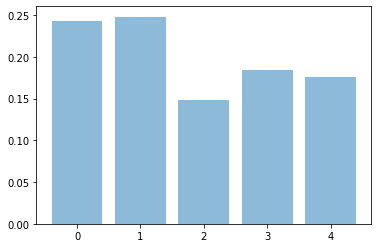

In [69]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

## Training the Model

In [87]:
from torch import optim

In [88]:
optimizer = optim.SGD(model.parameters(), lr=0.02, nesterov=True, momentum=0.1)
#optimizer = optim.SGD(model.parameters(), lr=0.05)

In [89]:
criterion = nn.NLLLoss()

In [90]:
%%time

epochs = 50

train_losses, train_accuracies, validation_losses, validation_accuracies = [], [], [], []

for e in range(epochs):
    
    training_loss = 0
    training_accuracy = 0
    
    for X, Y in dataloader_train:
        X = X.cuda()
        Y = Y.cuda()
    
        # Reset Gradients
        optimizer.zero_grad()
        
        # Forward, Loss, Backwards, Update
        output = model(X)
        loss = criterion(output, Y)
        loss.backward()
        optimizer.step()
        
        # Calculate Metrics
        training_loss += loss.item()
        training_accuracy += torch.sum(torch.exp(output).topk(1)[1].view(-1) == Y).item()
        
    else:
        validation_loss = 0
        validation_accuracy = 0
        
        with torch.no_grad():
            for X, Y in dataloader_val:
                X = X.cuda()
                Y = Y.cuda()  
                
                output_validation = model(X)
                loss_val = criterion(output_validation, Y)
                validation_loss += loss_val.item()
                validation_accuracy += torch.sum(torch.exp(output_validation).topk(1, dim=1)[1].view(-1) == Y).item()
        
        training_loss /= len(train_data)
        training_accuracy /= len(train_data)
        validation_loss /= len(val_data)
        validation_accuracy /= len(val_data)
        
        # Saving metrics
        train_losses.append(training_loss)
        train_accuracies.append(training_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        
        print("Epoch: {}/{}\n".format(e+1, epochs),
              "Training Loss: {:.3f}\n".format(training_loss),
              "Training Accuracy: {:.3f}\n".format(training_accuracy),
              "Validation Loss: {:.3f}\n".format(validation_loss),
              "Validation Accuracy: {:.3f}\n".format(validation_accuracy))

Epoch: 1/50
 Training Loss: 0.015
 Training Accuracy: 0.925
 Validation Loss: 0.048
 Validation Accuracy: 0.345

Epoch: 2/50
 Training Loss: 0.013
 Training Accuracy: 0.936
 Validation Loss: 0.049
 Validation Accuracy: 0.348

Epoch: 3/50
 Training Loss: 0.012
 Training Accuracy: 0.944
 Validation Loss: 0.049
 Validation Accuracy: 0.345

Epoch: 4/50
 Training Loss: 0.011
 Training Accuracy: 0.950
 Validation Loss: 0.050
 Validation Accuracy: 0.344

Epoch: 5/50
 Training Loss: 0.011
 Training Accuracy: 0.959
 Validation Loss: 0.051
 Validation Accuracy: 0.346

Epoch: 6/50
 Training Loss: 0.010
 Training Accuracy: 0.964
 Validation Loss: 0.051
 Validation Accuracy: 0.341

Epoch: 7/50
 Training Loss: 0.009
 Training Accuracy: 0.969
 Validation Loss: 0.052
 Validation Accuracy: 0.354

Epoch: 8/50
 Training Loss: 0.008
 Training Accuracy: 0.975
 Validation Loss: 0.052
 Validation Accuracy: 0.348

Epoch: 9/50
 Training Loss: 0.008
 Training Accuracy: 0.977
 Validation Loss: 0.053
 Validation 

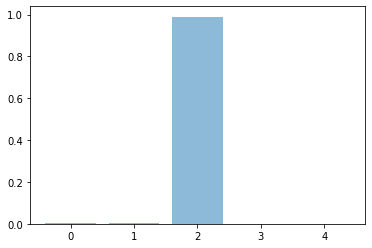

In [91]:
plt.bar(range(0,5), np.exp(model(X_dash).detach().cpu().numpy()[0]), alpha=0.5);

In [92]:
Y_dash[0]

tensor(2, device='cuda:0')

In [93]:
xt, yt = row2tensor(train_data[4])

In [94]:
XT = torch.LongTensor(xt)

In [95]:
XT = XT.view(1, 200)

In [96]:
XT.shape

torch.Size([1, 200])

In [97]:
model(XT.cuda())

tensor([[ -8.2089,  -0.0121,  -6.7197,  -4.5520, -11.2555]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

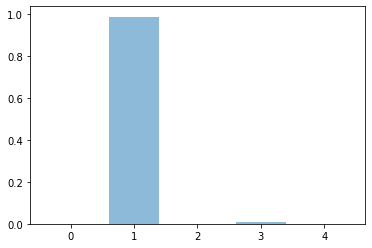

In [98]:
plt.bar(range(0,5), np.exp(model(XT.cuda()).detach().cpu().numpy()[0]), alpha=0.5);

In [99]:
yt

1

In [100]:
train_losses

[0.014709501173963833,
 0.01349206023787794,
 0.012458358043813147,
 0.011465768429181232,
 0.010573313076837813,
 0.00977781642102065,
 0.009051508247011815,
 0.008402174553855418,
 0.007783308231791254,
 0.007241359747091595,
 0.006740789957726785,
 0.006295383177717777,
 0.005872905480884316,
 0.0054968489435138984,
 0.0051494392648626895,
 0.004823763810559409,
 0.004533834101939418,
 0.004271358636805196,
 0.004027835274412699,
 0.003803375380040884,
 0.0035919154012384433,
 0.0033987044143562305,
 0.0032162870740470844,
 0.003054722431230836,
 0.0029035500849750187,
 0.0027658490162126327,
 0.002626661432929153,
 0.002504355961805058,
 0.002385854863017091,
 0.0022875856101834805,
 0.0021822267185987168,
 0.0020917704896499354,
 0.002010312112438904,
 0.0019233751699666713,
 0.0018442432028297807,
 0.0017733231920077212,
 0.0017070393383067802,
 0.0016443995368255354,
 0.0015832923549433352,
 0.001532686818199213,
 0.0014791614444467566,
 0.0014255726733247284,
 0.001378068068001

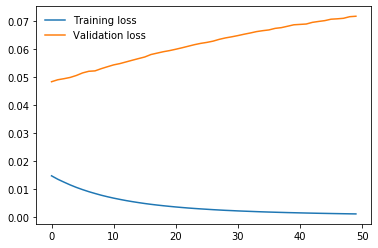

In [101]:
plt.plot(train_losses, label='Training loss')
plt.plot(validation_losses, label='Validation loss')
plt.legend(frameon=False);

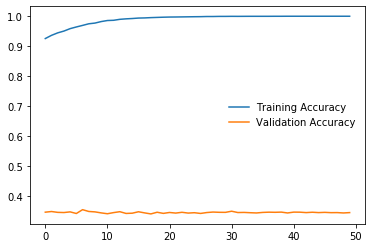

In [102]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.legend(frameon=False);

# Old

In [ ]:
import pandas as pd 

In [ ]:
train = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/train.csv", header=None)
test = pd.read_csv("/home/flennic/git/text-mining-project/src/data/processed/test.csv", header=None) 

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
import logging
import torch
from transformers import BertTokenizer, BertModel, BertForSequenceClassification

logger = logging.getLogger(__name__)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
input_ids1 = torch.tensor(tokenizer.encode("Hello, my dog is cute".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
input_ids2 = torch.tensor(tokenizer.encode("Hello, my cat is ugly".lower(), add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1

In [ ]:
input_ids1.shape

In [ ]:
input_ids = torch.cat((input_ids1, input_ids2))

In [ ]:
input_ids.shape

In [ ]:
labels = torch.tensor([0, 1]).unsqueeze(0).to('cuda')   # Batch size 1

In [ ]:
labels

In [ ]:
outputs = model(input_ids, labels=labels)

In [ ]:
outputs

In [ ]:
loss, logits = outputs[:2]

In [ ]:
import numpy as np

In [ ]:
np.exp(logits.detach().cpu().numpy())

In [ ]:
outputs = model(input_ids)

In [ ]:
outputs

## Raw BERT

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased')

In [ ]:
model.config

In [ ]:
model.eval();

In [ ]:
model.to('cuda');

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', output_hidden_states=True)
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0).to('cuda')  # Batch size 1
outputs = model(input_ids)
last_hidden_states = outputs[0]  # The last hidden-state is the first element of the output tuple

In [ ]:
tokenizer.tokenize("Hello, my dog is cute")

In [ ]:
tokenizer.cls_token

In [ ]:
tokenizer.convert_tokens_to_ids("[CLS]")

In [ ]:
input_ids

In [ ]:
outputs[1].shape

In [ ]:
outputs[0].shape

In [ ]:
outputs[0][0, 0,:].shape

In [ ]:
a = ("a", "b", "c")

In [ ]:
b = (1, 2) + a

In [ ]:
b

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
!pwd

In [ ]:
model = KeyedVectors.load_word2vec_format('src/data/embeddings/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
model["hello"].shape